# Support Vector Machines Lab

In this lab we will explore several datasets with SVMs. The assets folder contains several datasets (in order of complexity):

- Breast cancer
- Spambase
- Car evaluation
- Mushroom

For each of these a `.names` file is provided with details on the origin of data.

In [41]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Exercise 1: Breast Cancer



## 1.a: Load the Data
Use `pandas.read_csv` to load the data and assess the following:
- Are there any missing values? (how are they encoded? do we impute them?)
- Are the features categorical or numerical?
- Are the values normalized?
- How many classes are there in the target?

Perform what's necessary to get to a point where you have a feature matrix `X` and a target vector `y`, both with only numerical entries.

In [42]:
df = pd.read_csv('../../assets/datasets/breast_cancer.csv', na_values='?')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
Sample_code_number             699 non-null int64
Clump_Thickness                699 non-null int64
Uniformity_of_Cell_Size        699 non-null int64
Uniformity_of_Cell_Shape       699 non-null int64
Marginal_Adhesion              699 non-null int64
Single_Epithelial_Cell_Size    699 non-null int64
Bare_Nuclei                    683 non-null float64
Bland_Chromatin                699 non-null int64
Normal_Nucleoli                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: float64(1), int64(10)
memory usage: 60.1 KB


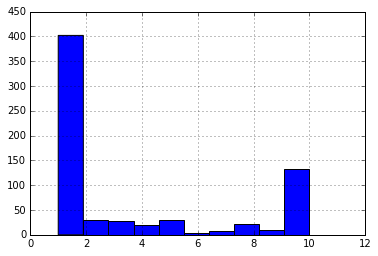

In [43]:
# 16 missing values in Bare_Nuclei
# replacing with mean not justified because distribution is very skewed:
df['Bare_Nuclei'].hist()

In [45]:
df['Class'].value_counts()

2    458
4    241
Name: Class, dtype: int64

In [4]:
# which class are the missing values?
df.ix[df['Bare_Nuclei'].isnull()]['Class'].value_counts()

2    14
4     2
Name: Class, dtype: int64

In [5]:
# mostly benign, I'll drop them (it's the majority class)
df = df.dropna().astype(int)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
Sample_code_number             683 non-null int64
Clump_Thickness                683 non-null int64
Uniformity_of_Cell_Size        683 non-null int64
Uniformity_of_Cell_Shape       683 non-null int64
Marginal_Adhesion              683 non-null int64
Single_Epithelial_Cell_Size    683 non-null int64
Bare_Nuclei                    683 non-null int64
Bland_Chromatin                683 non-null int64
Normal_Nucleoli                683 non-null int64
Mitoses                        683 non-null int64
Class                          683 non-null int64
dtypes: int64(11)
memory usage: 64.0 KB


In [7]:
X = df.drop(['Sample_code_number', 'Class'], axis = 1)
y = df['Class'] == 4

In [8]:
# data all has the same 1-10 scale so don't normalize

## 1.b: Model Building

- What's the baseline for the accuracy?
- Initialize and train a linear svm. What's the average accuracy score with a 3-fold cross validation?
- Repeat using an rbf classifier. Compare the scores. Which one is better?
- Are your features normalized? if not, try normalizing and repeat the test. Does the score improve?
- What's the best model?
- Print a confusion matrix and classification report for your best model using:
        train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

**Check:** To decide which model is best, look at the average cross validation score. Are the scores significantly different from one another?

In [9]:
#baseline => 65%
y.value_counts() / len(y)

False    0.650073
True     0.349927
Name: Class, dtype: float64

In [10]:
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score

all_scores = []
model = SVC(kernel='linear')

def do_cv(model, X, y, cv):
    scores = cross_val_score(model, X, y, cv=cv)
    print model
    sm = scores.mean()
    ss = scores.std()
    res = (sm, ss)
    print "Average score: {:0.3}+/-{:0.3}".format(*res)
    return res

all_scores.append(do_cv(model, X, y, 3))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Average score: 0.965+/-0.0179


In [11]:
model = SVC(kernel='rbf')
all_scores.append(do_cv(model, X, y, 3))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Average score: 0.958+/-0.0251


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), SVC(kernel='linear'))
all_scores.append(do_cv(model, X, y, 3))

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Average score: 0.966+/-0.0161


In [13]:
model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
all_scores.append(do_cv(model, X, y, 3))

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Average score: 0.968+/-0.018


(0.9, 1)

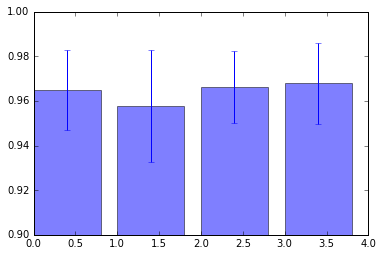

In [14]:
plt.bar(xrange(4),
        [m[0] for m in all_scores],
        yerr=[m[1] for m in all_scores],
        alpha = 0.5)
plt.ylim(0.9,1)

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

def print_cm_cr(y_true, y_pred, names):
    """prints the confusion matrix and the classification report"""
    cm = confusion_matrix(y_true, y_pred)
    cols = ['pred_' + c for c in names]
    dfcm = pd.DataFrame(cm, columns = cols, index = names)
    print dfcm
    print
    print classification_report(y_true, y_pred)

In [16]:
from sklearn.cross_validation import train_test_split

In [17]:
model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

In [18]:
def do_cm_cr(model, X, y, names):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print_cm_cr(y_test, y_pred, names)

do_cm_cr(model, X, y, ['benign', 'cancer'])

        pred_benign  pred_cancer
benign          142            5
cancer            3           76

             precision    recall  f1-score   support

      False       0.98      0.97      0.97       147
       True       0.94      0.96      0.95        79

avg / total       0.96      0.96      0.96       226



**Check:** Are there more false positives or false negatives? Is this good or bad?

> Answer:
More false negatives is bad from the point of view of the patient and good from the point of view of the insurance company. Viceversa otherwise.

## 1.c: feature selection

Use any of the strategies offered by `sklearn` to select the most important features.

Repeat the cross validation with only those 5 features. Does the score change?

In [19]:
from sklearn.feature_selection import SelectKBest, chi2

In [20]:
def do_k_best(X, y, k=5):
    selector = SelectKBest(chi2, k=k)
    selected_data = selector.fit_transform(X, y)
    selected_columns = X.columns[selector.get_support()]
    X_new = pd.DataFrame(selected_data, columns=selected_columns)
    return X_new



In [21]:
X_new = do_k_best(X, y, 5)
do_cm_cr(model, X_new, y, ['benign', 'cancer'])

        pred_benign  pred_cancer
benign          142            5
cancer            4           75

             precision    recall  f1-score   support

      False       0.97      0.97      0.97       147
       True       0.94      0.95      0.94        79

avg / total       0.96      0.96      0.96       226



almost the same result, with only 5 features!

## 1.d: Learning Curves

Learning curves are useful to study the behavior of training and test errors as a function of the number of datapoints available.

- Plot learning curves for train sizes between 10% and 100% (use StratifiedKFold with 5 folds as cross validation)
- What can you say about the dataset? do you need more data or do you need a better model?

In [22]:
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import StratifiedKFold
from bokeh.plotting import figure, output_notebook, show
output_notebook()

def do_learning_curve(model, X, y, sizes=np.linspace(0.1, 1.0, 10), y_range=(0.9,1)):
    sizes, tr_scores, te_scores = learning_curve(model,
                                                 X,
                                                 y,
                                                 train_sizes=sizes,
                                                 cv = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=0),
                                                 n_jobs=-1)
    # Create our base figure
    p = figure(title='Learning Curve',y_range=y_range)

    # Create our Training score line
    p.line(x=sizes,
           y=tr_scores.mean(axis=1),
           color='red',
           legend="Train Scores")

    #Create our Testing score line
    p.line(x=sizes,
           y=te_scores.mean(axis=1),
           color='blue',
           legend= "Test Scores")

    #Move our legend around
    p.legend.location = "top_right"

    # Render the plot!!
    show(p)
    
do_learning_curve(model, X, y)

Loading BokehJS ...

##  1.e: Grid search

Use the grid_search function to explore different kernels and values for the `C` parameter.

- Can you improve on your best previous score?
- Print the best parameters and the best score

In [23]:
from sklearn import grid_search

parameters = {'svc__kernel':('linear', 'rbf'), 'svc__C':[0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), SVC())

def do_grid_search(input_model, X, y, parameters):
    model = grid_search.GridSearchCV(input_model, parameters, cv=StratifiedKFold(y, 5), n_jobs=-1)
    model.fit(X, y)
    print "Best Params:", model.best_params_
    print "Best Score:", model.best_score_
    return model.best_estimator_

In [24]:
best_model = do_grid_search(model, X, y, parameters)

Best Params: {'svc__kernel': 'linear', 'svc__C': 0.01}
Best Score: 0.96925329429


In [25]:
best_model

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [26]:
model

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

# Exercise 2
Now that you've completed steps 1.a through 1.e it's time to tackle some harder datasets. But before we do that, let's encapsulate a few things into functions so that it's easier to repeat the analysis.

## 2.a: Cross Validation
Implement a function `do_cv(model, X, y, cv)` that does the following:
- Calculates the cross validation scores
- Prints the model
- Prints and returns the mean and the standard deviation of the cross validation scores

> Answer: see above

## 2.b: Confusion Matrix and Classification report
Implement a function `do_cm_cr(model, X, y, names)` that automates the following:
- Split the data using `train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)`
- Fit the model
- Prints confusion matrix and classification report in a nice format

**Hint:** names is the list of target classes

> Answer: see above

## 2.c: Learning Curves
Implement a function `do_learning_curve(model, X, y, sizes)` that automates drawing the learning curves:
- Allow for sizes input
- Use 5-fold StratifiedKFold cross validation

> Answer: see above

## 2.d Grid Search
Implement a function `do_grid_search(model, parameters)` that automates the grid search by doing:
- Calculate grid search
- Print best parameters
- Print best score
- Return best estimator


> Answer: see above

# Exercise 3
Using the functions above, analyze the Spambase dataset.

Notice that now you have many more features. Focus your attention on step C => feature selection

- Load the data and get to X, y
- Select the 15 best features
- Perform grid search to determine best model
- Display learning curves

In [27]:
df = pd.read_csv('../../assets/datasets/spambase.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
word_freq_make                4601 non-null float64
word_freq_address             4601 non-null float64
word_freq_all                 4601 non-null float64
word_freq_3d                  4601 non-null float64
word_freq_our                 4601 non-null float64
word_freq_over                4601 non-null float64
word_freq_remove              4601 non-null float64
word_freq_internet            4601 non-null float64
word_freq_order               4601 non-null float64
word_freq_mail                4601 non-null float64
word_freq_receive             4601 non-null float64
word_freq_will                4601 non-null float64
word_freq_people              4601 non-null float64
word_freq_report              4601 non-null float64
word_freq_addresses           4601 non-null float64
word_freq_free                4601 non-null float64
word_freq_business            4601 non-null float64
word_freq

In [28]:
X = df.drop('class', axis=1)
y = df['class']
do_cm_cr(model, X, y, ['ham', 'spam'])

      pred_ham  pred_spam
ham        879         41
spam        74        525

             precision    recall  f1-score   support

          0       0.92      0.96      0.94       920
          1       0.93      0.88      0.90       599

avg / total       0.92      0.92      0.92      1519



In [29]:
# select the 15 best features
X_new = do_k_best(X, y, 15)
do_cm_cr(model, X_new, y, ['ham', 'spam'])

      pred_ham  pred_spam
ham        869         51
spam        94        505

             precision    recall  f1-score   support

          0       0.90      0.94      0.92       920
          1       0.91      0.84      0.87       599

avg / total       0.90      0.90      0.90      1519



In [30]:
# perform grid search to determine best model
parameters = {'svc__kernel':('linear', 'rbf'), 'svc__C':[0.01, 0.1, 1.0, 10, 100]}
pipe = make_pipeline(StandardScaler(), SVC())
best_model = do_grid_search(pipe, X_new, y, parameters)
best_model

Best Params: {'svc__kernel': 'rbf', 'svc__C': 10}
Best Score: 0.901543142795


Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [31]:
# display learning curves
do_learning_curve(best_model, X_new, y,
                  sizes=np.linspace(0.4,1.0,5),
                  y_range=(0.7, 1))

# Exercise 4
Repeat steps 1.a - 1.e for the car dataset. Notice that now features are categorical, not numerical.

- Find a suitable way to encode them
- How does this change our modeling strategy?

Also notice that the target variable `acceptability` has 4 classes. How do we encode them?


In [32]:
df = pd.read_csv('../../assets/datasets/car.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying           1728 non-null object
maint            1728 non-null object
doors            1728 non-null object
persons          1728 non-null object
lug_boot         1728 non-null object
safety           1728 non-null object
acceptability    1728 non-null object
dtypes: object(7)
memory usage: 94.6+ KB


In [33]:
df['acceptability'].value_counts() / len(df)

unacc    0.700231
acc      0.222222
good     0.039931
vgood    0.037616
Name: acceptability, dtype: float64

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = df['acceptability']
le.fit(labels)
y = le.transform(labels)
le.classes_

array(['acc', 'good', 'unacc', 'vgood'], dtype=object)

In [35]:
X = pd.get_dummies(df.drop('acceptability', axis = 1))

In [36]:
parameters = {'svc__kernel':('linear', 'rbf'), 'svc__C':[0.01, 0.1, 1.0, 10, 100]}
pipe = make_pipeline(StandardScaler(), SVC())

best_model = do_grid_search(pipe, X, y, parameters)

Best Params: {'svc__kernel': 'rbf', 'svc__C': 10}
Best Score: 0.856481481481


In [37]:
do_cm_cr(best_model, X, y, le.classes_)

       pred_acc  pred_good  pred_unacc  pred_vgood
acc         127          0           0           0
good          1         22           0           0
unacc         1          0         399           0
vgood         0          0           0          21

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       127
          1       1.00      0.96      0.98        23
          2       1.00      1.00      1.00       400
          3       1.00      1.00      1.00        21

avg / total       1.00      1.00      1.00       571



In [38]:
do_learning_curve(best_model, X, y, sizes=np.linspace(0.25, 1.0, 10), y_range=(0.7,1.1))

# Bonus
Repeat steps 1.a - 1.e for the mushroom dataset. Notice that now features are categorical, not numerical. This dataset is quite large.

- How does this change our modeling strategy?
- Can we use feature selection to improve this?
